# Imports

In [1]:
# pyright: reportUnknownArgumentType=false, reportCallIssue=false, reportAttributeAccessIssue=false, reportOptionalSubscript=false, reportArgumentType=false
from rich.console import Console
from rich.table import Table
from rich.theme import Theme

from finesse.model import Model
from finesse.analysis.actions.axes import Noxaxis, Xaxis
from finesse.solutions import SeriesSolution
from finesse.analysis.actions import (
    TemporaryParameters,
    Change,
    Maximize,
    Minimize,
    Series,
    FrequencyResponse,
)
from finesse.components import Mirror, SignalGenerator
from finesse.detectors import QuantumNoiseDetector

from pathlib import Path
from typing import NamedTuple
import re

from matplotlib.axes import Axes
from matplotlib.pyplot import figure, show


from numpy import linspace, geomspace, pi, angle, where, diff, mean, loadtxt, load
from scipy.io.matlab import loadmat

from science_signal import Signal

In [2]:
from gettext import install
from logging import getLogger

In [3]:
install(__name__)
logger = getLogger(__name__)
theme = Theme(
    {
        "strong": "cyan underline",
        "result": "red bold",
    }
)
console = Console(theme=theme)

## Paramètres généraux

In [4]:
C_POWER = 25  # en Whatt
C_DARK_FRINGE = 8e-3  # en Whatt

## Modèle simplifié de Virgo

/home/demagny/codes/python/finesse/finesse-simulation-04/.venv/lib/python3.13/site-packages/pygraphviz/agraph.py:1403: RuntimeWarning: Warning: Illegal value sgd for attribute "mode" in graph  - ignored

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


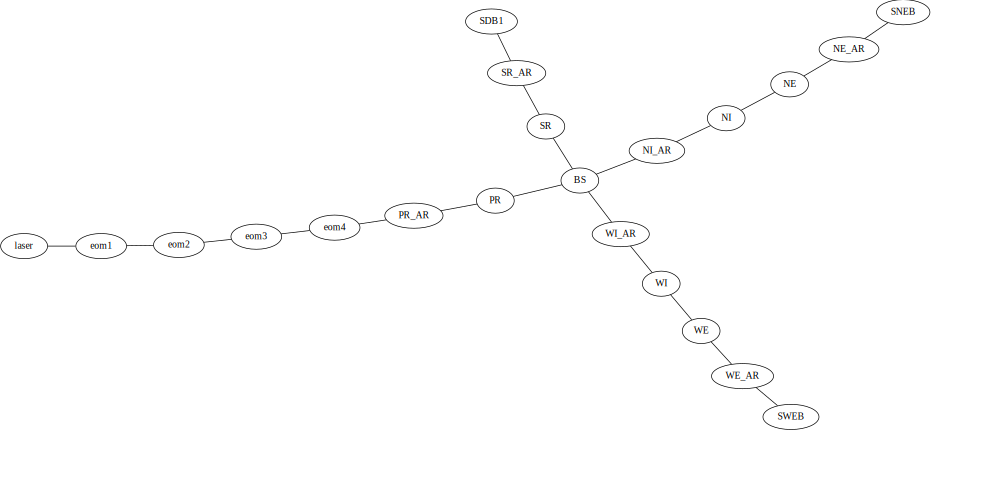

In [5]:
%matplotlib ipympl
model_file = Path("model.kat")
model = Model()
model.phase_config(zero_k00=False, zero_tem00_gouy=True)
model.modes(modes="off")  # pyright: ignore[reportUnusedCallResult]
model.parse(model_file.read_text())
model.lambda0 = model.get("wavelength")
model.laser.P = C_POWER
model.plot_graph()  # pyright: ignore[reportUnusedCallResult]
show()

In [6]:
result = model.run(
    TemporaryParameters(
        Series(
            Change(
                {
                    "SR.misaligned": True,
                    "PR.misaligned": True,
                    "eom1.midx": 0,
                    "eom2.midx": 0,
                    "eom3.midx": 0,
                    "eom4.midx": 0,
                }
            ),
            Maximize(
                model.get("NE_p1"),
                model.get("NORTH_ARM.DC"),
                bounds=[-180, 180],
                tol=1e-14,
            ),
            Maximize(
                model.get("WE_p1"),
                model.get("WEST_ARM.DC"),
                bounds=[-180, 180],
                tol=1e-14,
            ),
            Minimize(
                model.get("SR_p2"), model.get("MICH.DC"), bounds=[-180, 180], tol=1e-14
            ),
            Change(
                {
                    "PR.misaligned": False,
                }
            ),
            Maximize(
                model.get("PR_p2"), model.get("PRCL.DC"), bounds=[-180, 180], tol=1e-14
            ),
            Change(
                {
                    "SR.misaligned": False,
                }
            ),
            Maximize(
                model.get("B1_DC"), model.get("SRCL.DC"), bounds=[-180, 180], tol=1e-14
            ),
            Change(
                {
                    "SRCL.DC": -90,
                },
                relative=True,
            ),
        ),
        exclude=[
            "NE.phi",
            "NI.phi",
            "WE.phi",
            "WI.phi",
            "SR.phi",
            "PR.phi",
            "NORTH_ARM.DC",
            "WEST_ARM.DC",
            "DARM.DC",
            "MICH.DC",
            "PRCL.DC",
            "SRCL.DC",
            "SR.misaligned",
            "eom1.midx",
            "eom2.midx",
            "eom3.midx",
            "eom4.midx",
        ],
    ),
)

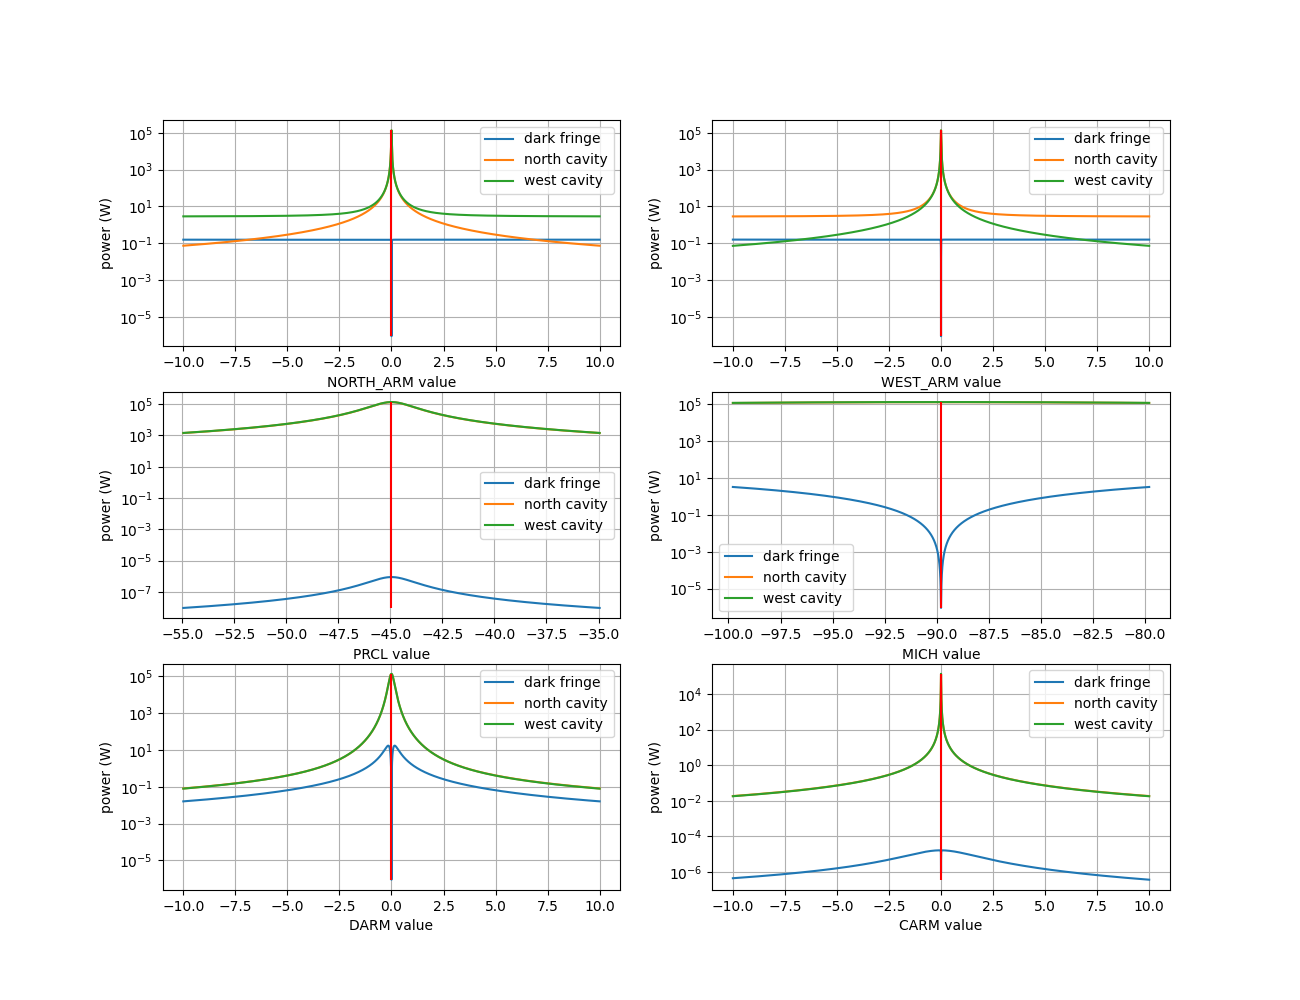

Degré de liberté 0.00164794921875 trouvé en 14 pas pour avoir une puissance de 0.007914176860517742 W sur B1

In [7]:
def compute_solutions(
    model: Model, DOF: str, padding: float, nb: int = 10000
) -> SeriesSolution:
    return model.run(
        Xaxis(
            model.get(DOF).DC,
            "lin",
            model.get(DOF).DC - padding,
            model.get(DOF).DC + padding,
            nb,
        )
    )


def display_ax(
    ax: Axes,
    solution: SeriesSolution,
    model: Model,
    DOF: str,
    padding: float,
    nb: int = 10000,
) -> Axes:
    x = linspace(model.get(DOF).DC - padding, model.get(DOF).DC + padding, nb + 1)
    _ = ax.semilogy(x, solution["SR_p2"], label="dark fringe")
    _ = ax.semilogy(x, solution["NE_p1"], label="north cavity")
    _ = ax.semilogy(x, solution["WE_p1"], label="west cavity")
    _ = ax.vlines(
        [model.get(DOF).DC],
        min(solution["SR_p2"]),
        max(solution["NE_p1"]),
        colors="red",
    )
    _ = ax.set_ylabel("power (W)")
    ax.grid()
    _ = ax.legend()
    return ax


class DisplayData(NamedTuple):
    DOF: str
    padding: float


data: list[DisplayData] = [
    DisplayData("NORTH_ARM", 10),
    DisplayData("WEST_ARM", 10),
    DisplayData("PRCL", 10),
    DisplayData("MICH", 10),
    DisplayData("DARM", 10),
    DisplayData("CARM", 10),
]

Figure = figure(figsize=(13, 10))
nb = int(1e4)

for i in range(len(data)):
    element: DisplayData = data[i]
    ax = Figure.add_subplot(3, 2, i + 1)
    solution = compute_solutions(model, element.DOF, element.padding, nb)
    _ = display_ax(ax, solution, model, element.DOF, element.padding, nb).set_xlabel(
        "{} value".format(element.DOF)
    )
show()

solution = model.run(Noxaxis())
result = solution["B1_DC"]
start, stop, nb = 0, 1, 0
while (abs(result - C_DARK_FRINGE) > 1e-4) and (nb < 100):
    nb += 1
    temp = start + (stop - start) / 2

    model.DARM.DC = temp
    solution = model.run(Noxaxis())
    result = solution["B1_DC"]
    if result > C_DARK_FRINGE:
        stop = temp
    else:
        start = temp
console.print(
    "Degré de liberté [result]{dof}[/result] trouvé en [strong]{nb} pas[/strong] pour avoir une puissance de [result]{result} W[/result] sur B1".format(
        nb=nb, dof=model.DARM.DC, result=result
    )
)

In [8]:
solution = model.run(Noxaxis())
console = Console()
table = Table(title="Puissances dans l'interferomètre")
table.add_column("position", justify="left", style="white")
table.add_column("puissance (W)", justify="left", style="cyan")

table.add_row("Injection", str(model.get("laser").P.eval()))
table.add_row("PR", str(solution["PR_p1"]))
table.add_row("cavité de recyclage de puissance", str(solution["PR_p2"]))
table.add_row("cavité ouest", str(solution["WE_p1"]))
table.add_row("cavité nord", str(solution["NE_p1"]))
table.add_row("frange noire", str(solution["SR_p2"]))
table.add_row("SNEB", str(solution["SNEB_DC"]))
table.add_row("SWEB", str(solution["SWEB_DC"]))
table.add_row("SDB1", str(solution["SDB1_DC"]))

console.print(table)

table = Table(title="DOF dans l'interferomètre")
table.add_column("nom", justify="left", style="white")
table.add_column("valeur", justify="left", style="magenta")

table.add_row("Bras nord", str(model.get("NORTH_ARM.DC")))
table.add_row("Bras ouest", str(model.get("WEST_ARM.DC")))
table.add_row("PR", str(model.get("PRCL.DC")))
table.add_row("SR", str(model.get("SRCL.DC")))
table.add_row("MICH", str(model.get("MICH.DC")))

console.print(table)

console = Console(theme=theme)
table = Table(title="")
table.add_column("nom", justify="left", style="white")
table.add_column("valeur", justify="left", style="cyan")
for i in range(1, model.west_arm.info_parameter_table().table.shape[0]):
    table.add_row(
        str(model.west_arm.info_parameter_table().table[i, 0]),
        str(model.west_arm.info_parameter_table().table[i, 1]),
    )
console.print(table)

             Puissances dans l'interferomètre              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ position                         ┃ puissance (W)        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ Injection                        │ 25.0                 │
│ PR                               │ 3.5170290886624462   │
│ cavité de recyclage de puissance │ 964.4848027884494    │
│ cavité ouest                     │ 135149.08955077862   │
│ cavité nord                      │ 133050.4589467552    │
│ frange noire                     │ 0.007915300832119847 │
│ SNEB                             │ 0.5971887081919476   │
│ SWEB                             │ 0.5810707836915688   │
│ SDB1                             │ 0.007914184774702517 │
└──────────────────────────────────┴──────────────────────┘

       DOF dans l'interferomètre        
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ nom        ┃ valeur                  ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Bras nord  │ 6.592588499188424e-06   │
│ Bras ouest │ -5.8479547500610346e-05 │
│ PR         │ -44.946681098699614     │
│ SR         │ -135.09400848257525     │
│ MICH       │ -89.79029219055182      │
└────────────┴─────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ nom                   ┃ valeur                          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ FSR                   │ 49968.74091606107               │
│ Loss                  │ 0.013848722846499961            │
│ Finesse               │ 450.5516190359727               │
│ FWHM                  │ 110.90569605093683              │
│ Storage time          │ 0.0028700950223295757           │
│ Pole                  │ 55.45284802546841               │
│ Round trip length     │ 5999.6                          │
│ Waist size            │ [0.00968668 0.00968668]         │
│ Waist position        │ [-1363.71492094 -1363.71492094] │
│ Stability (m-factor)  │ [0.7409226 0.7409226]           │
│ Stability (g-factor)  │ [0.8704613 0.8704613]           │
│ Round trip gouy phase │ [317.81006617 317.81006617]     │
│ Mode separation       │ [5856.04964666 5856.04964666]   │
│ Resolution            │ [52.80206387 52.80206387]       │
│ Stable                │ True                            │
│ Critically stable     │ False                           │
└───────────────────────┴─────────────────────────────────┘

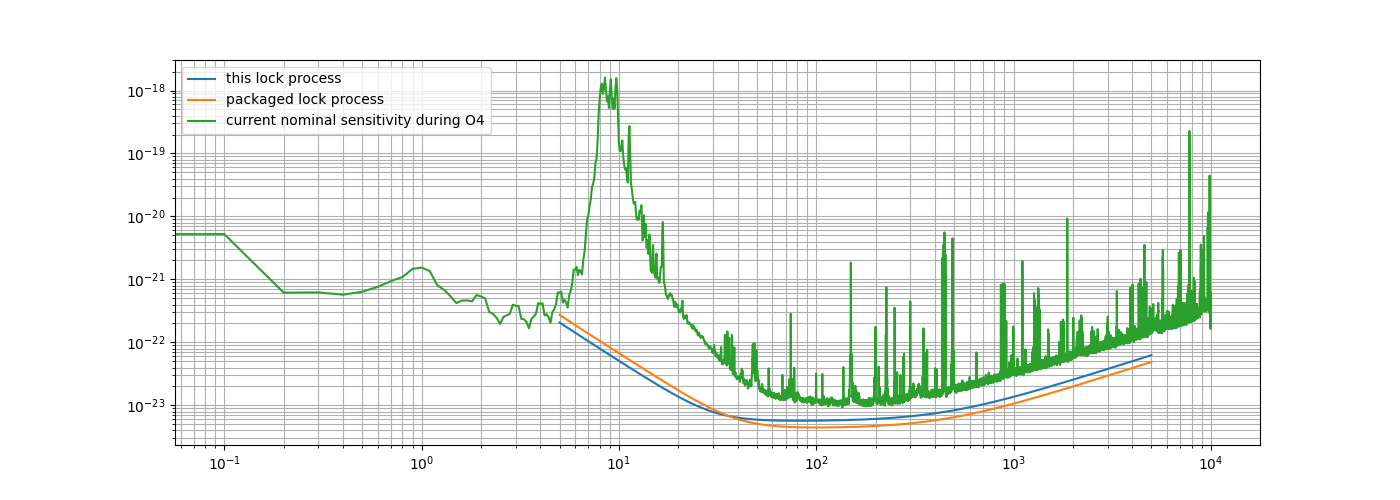

/home/demagny/codes/python/finesse/finesse-simulation-04/.venv/lib/python3.13/site-packages/finesse/analysis/actions/base.py:157: UserWarning: Signal frequency (fsig) was set to None but simulation needs it. Setting default value of 1 Hz
  self.__sim.__enter__()


Le pôle de la fonction de transfert DARM est à 445.2 Hz

             Position des différents miroirs              
┏━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ miroir ┃ offset (°)          ┃ offset (m)              ┃
┡━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ NE     │ 44.894328713255035  │ 2.653753652827965e-07   │
│ NE_AR  │ 44.894328713255035  │ 2.653753652827965e-07   │
│ NI     │ 44.89514609527591   │ 2.6538019691874205e-07  │
│ NI_AR  │ 44.89514609527591   │ 2.6538019691874205e-07  │
│ WE     │ -44.894380600214035 │ -2.653756719923763e-07  │
│ WE_AR  │ -44.894380600214035 │ -2.653756719923763e-07  │
│ WI     │ -44.89514609527591  │ -2.6538019691874205e-07 │
│ WI_AR  │ -44.89514609527591  │ -2.6538019691874205e-07 │
│ PR     │ -44.946681098699614 │ -2.656848260500911e-07  │
│ PR_AR  │ -44.946681098699614 │ -2.656848260500911e-07  │
│ SR     │ -135.09400848257525 │ -7.985556945858894e-07  │
│ SR_AR  │ -135.09400848257525 │ -7.985556945858894e-07  │
└────────┴─────────────────────┴─────────────────────────┘

In [9]:
def get_QNLS(
    model: Model, start: int = 5, stop: int = 1000, nb: int = 100
) -> SeriesSolution:
    new_model = model.deepcopy()
    new_model.fsig.f = 1
    new_model.add(SignalGenerator("darmx", new_model.space_NI_NE.h, 1, 0))
    new_model.add(SignalGenerator("darmy", new_model.space_WI_WE.h, 1, 180))
    new_model.add(QuantumNoiseDetector("NSR_with_RP", new_model.SR.p2.o, True))
    return new_model.run(Xaxis(new_model.get("fsig.f"), "log", start, stop, nb))


model._settings.phase_config.zero_k00 = False

solution = get_QNLS(model, 5, 5000, 10000)


def dumb_parse(value: str = ""):
    regex = re.compile("\\((\\d+\\.\\d+e[+-]\\d{2})([+-]\\d+\\.\\d+e[+-]\\d{2})j\\)")
    result = re.search(regex, value)
    if result:
        return float(result.groups()[0]) + 1j * float(result.groups()[1])
    raise Exception(value)


QNLS = load("sensitivities/finesse-virgo.npy")
current_O4_sensitivity_ASD = loadtxt("sensitivities/O4_nominal_reference.txt")

Figure = figure(figsize=(14, 5))
_ = Figure.gca().loglog(
    solution.x1, abs(solution["NSR_with_RP"]), label="this lock process"
)
_ = Figure.gca().loglog(
    QNLS[0],
    QNLS[1],
    label="packaged lock process",
)
_ = Figure.gca().loglog(
    current_O4_sensitivity_ASD[0],
    abs(current_O4_sensitivity_ASD[1]),
    label="current nominal sensitivity during O4",
)
_ = Figure.gca().legend()
Figure.gca().grid(True, "both", "both")
show()

solution = model.run(FrequencyResponse(geomspace(5, 10000, 1000), ["DARM"], ["B1.I"]))
maximum_amplitude_step: float = max(abs(diff(angle(solution["B1.I", "DARM"]))))
pole_index = round(
    mean(
        where(
            abs(angle(solution["B1.I", "DARM"]) + pi / 4) < maximum_amplitude_step * 2
        )
    )
)  # find the index where the curve is the closest to -45°
console.print(
    "Le [strong]pôle[/strong] de la fonction de transfert [strong]DARM[/strong] est à [result]{:.1f}[/result] Hz".format(
        solution.f[pole_index]
    )
)

table = Table(title="Position des différents miroirs")
table.add_column("miroir", justify="left", style="white")
table.add_column("offset (°)", justify="left", style="white")
table.add_column("offset (m)", justify="left", style="white")

for name in [
    "NE",
    "NE_AR",
    "NI",
    "NI_AR",
    "WE",
    "WE_AR",
    "WI",
    "WI_AR",
    "PR",
    "PR_AR",
    "SR",
    "SR_AR",
]:
    element: Mirror = model.get(name)
    table.add_row(
        str(element.name),
        str(element.phi.eval()),
        str(element.phi.eval() * model.lambda0 / 180),
    )

console.print(table)

## Comparaison avec Optickle

In [10]:
model.SNEB.phi = model.NE.phi - 45
model.SWEB.phi = model.WE.phi - 45
model.SDB1.phi = model.SR.phi + 45

B1_detector = "B1_DDC.DC"

quad_tf: dict[str, SeriesSolution] = dict()
in_tf: dict[str, SeriesSolution] = dict()

for bench_name in ["SNEB", "SWEB", "SDB1"]:
    quad_tf[bench_name] = model.run(
        FrequencyResponse(
            geomspace(5, 10000, 1000), ["{}_z".format(bench_name)], [B1_detector]
        )
    )

quad_tf["DARM"] = model.run(
    FrequencyResponse(geomspace(5, 10000, 1000), ["DARM"], [B1_detector])
)

model.SNEB.phi = model.NE.phi
model.SWEB.phi = model.WE.phi
model.SDB1.phi = model.SR.phi

for bench_name in ["SNEB", "SWEB", "SDB1"]:
    in_tf[bench_name] = model.run(
        FrequencyResponse(
            geomspace(5, 10000, 1000), ["{}_z".format(bench_name)], [B1_detector]
        )
    )

in_tf["DARM"] = model.run(
    FrequencyResponse(geomspace(5, 10000, 1000), ["DARM"], [B1_detector])
)

modelisation_file = Path("scatterCoupling_25_8.mat")

modelisation_data = loadmat(modelisation_file)
coupling_data: dict[str, list[Signal]] = dict()
old_couplings = ["SNEB", "SWEB", "SDB1"]
for coupling in old_couplings:
    coupling_data[coupling] = [
        Signal(
            modelisation_data["freq"][0],
            abs(values),
        )
        for values in modelisation_data["{}coupling".format(coupling)]
    ]
DARMcoupling = Signal(
    modelisation_data["freq"][0],
    modelisation_data["DARMmat"][0],
)

### En fonction de la phase

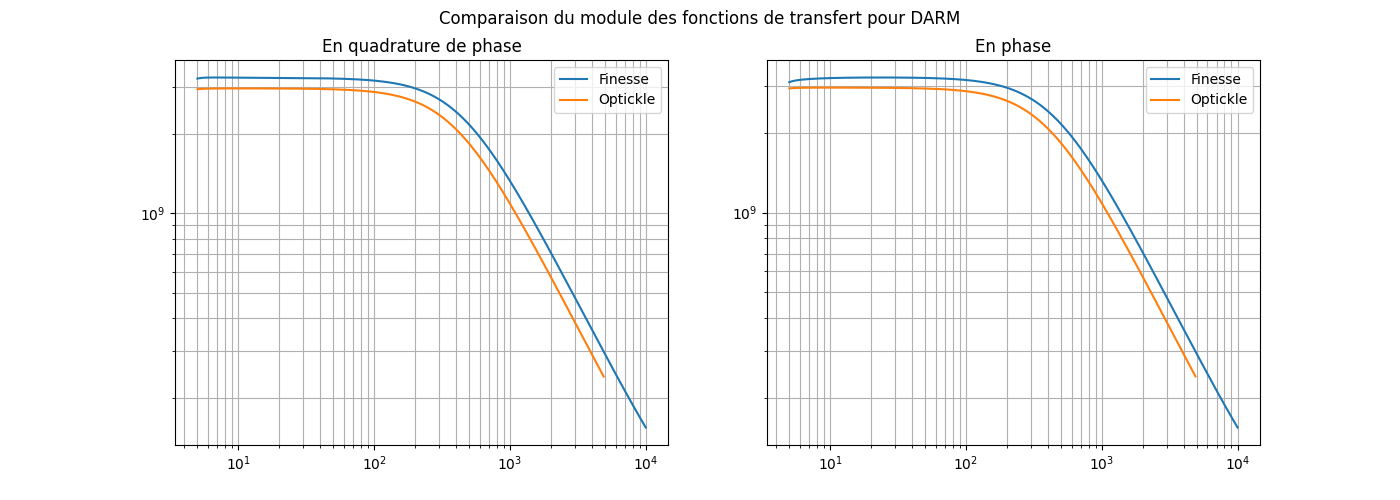

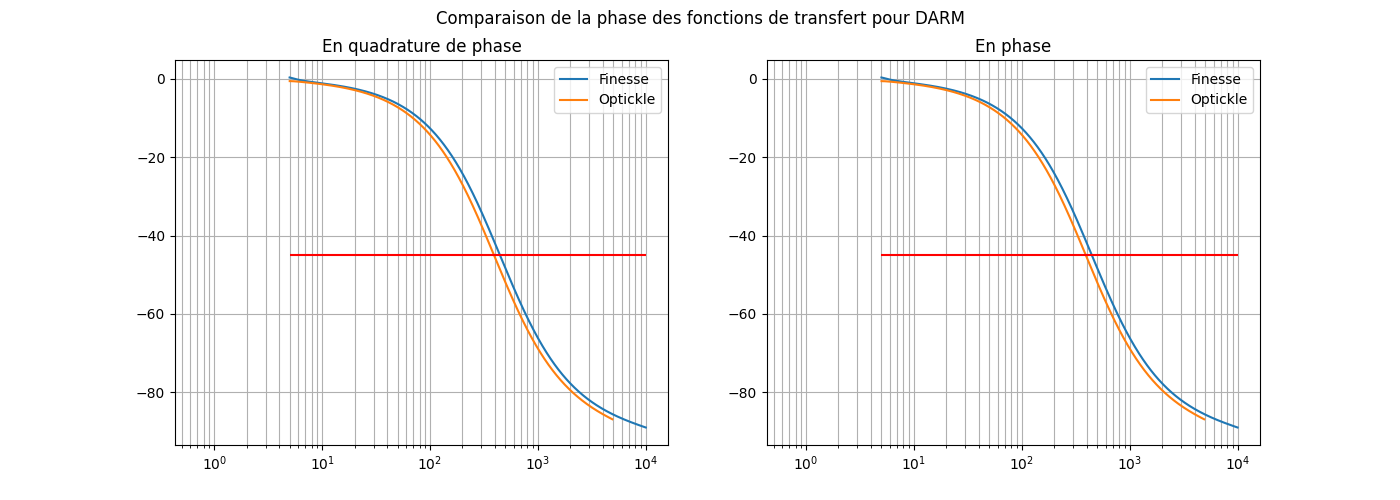

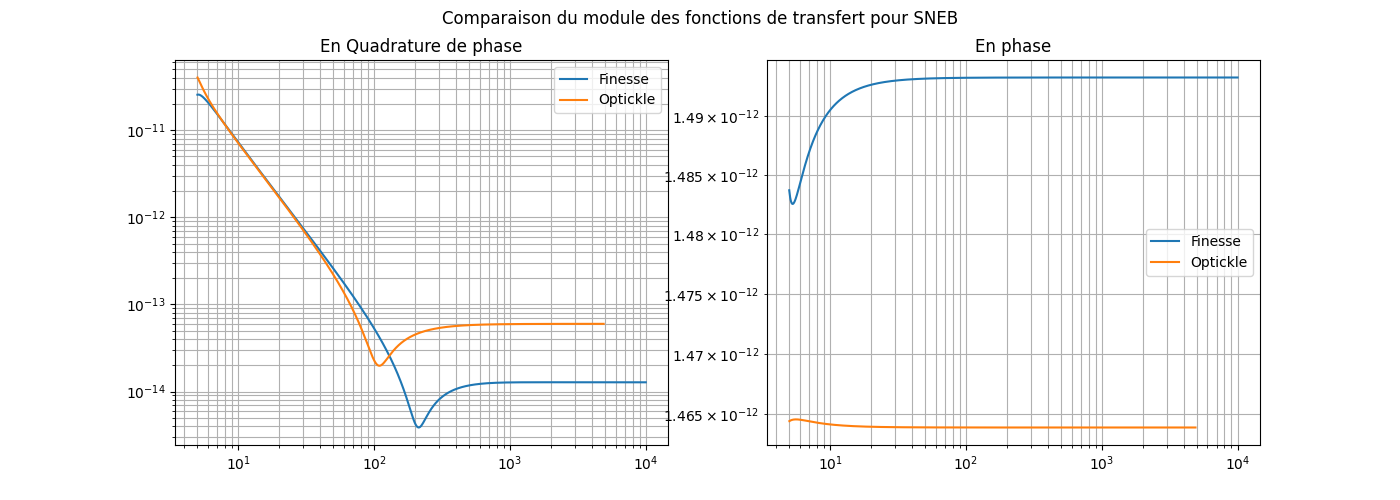

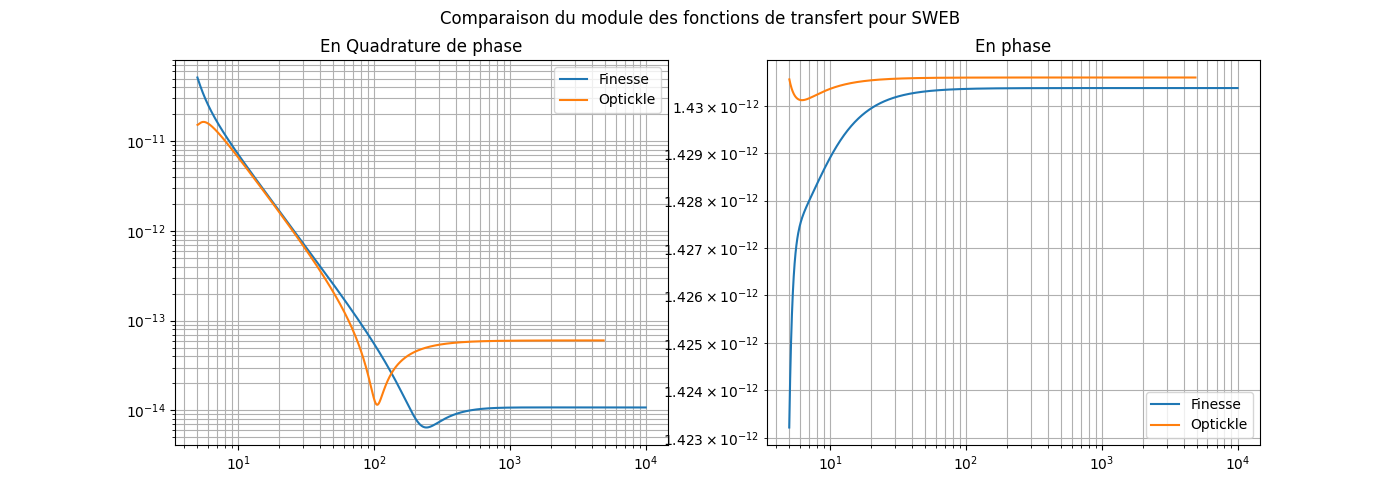

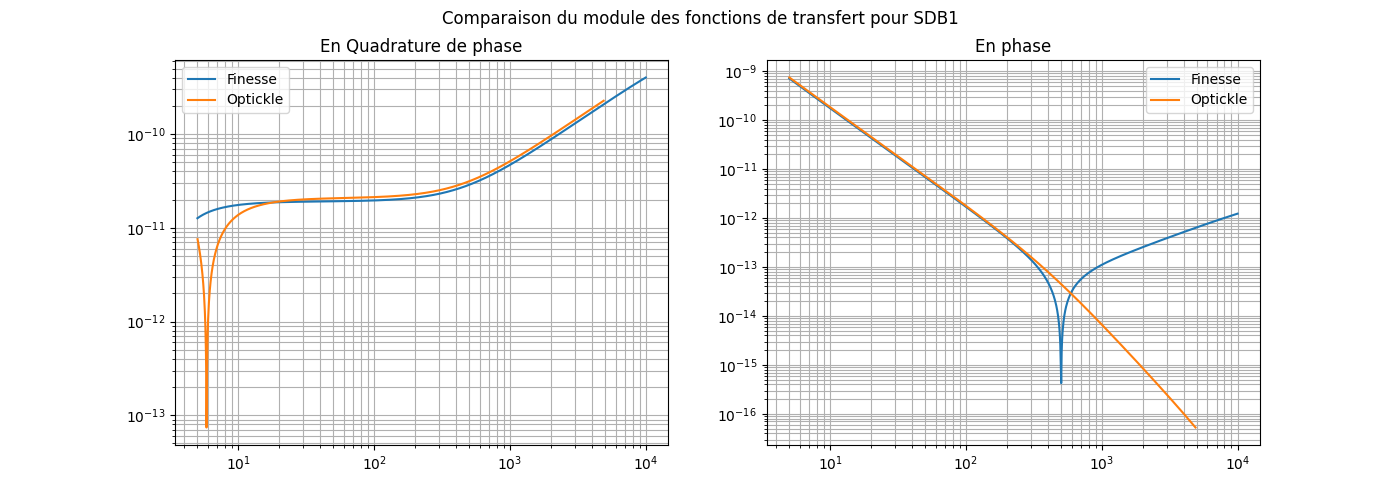

In [11]:
Figure = figure(figsize=(14, 5))
_ = Figure.suptitle("Comparaison du module des fonctions de transfert pour DARM")
ax = Figure.add_subplot(1, 2, 1)
_ = ax.loglog(quad_tf["DARM"].f, abs(quad_tf["DARM"][B1_detector, "DARM"]), label="Finesse")
_ = ax.loglog(DARMcoupling.x, abs(DARMcoupling.y), label="Optickle")
_ = ax.set_title("En quadrature de phase")
_ = ax.legend()
ax.grid(True, "both", "both")
ax = Figure.add_subplot(1, 2, 2)
_ = ax.loglog(in_tf["DARM"].f, abs(in_tf["DARM"][B1_detector, "DARM"]), label="Finesse")
_ = ax.loglog(DARMcoupling.x, abs(DARMcoupling.y), label="Optickle")
_ = ax.set_title("En phase")
_ = ax.legend()
ax.grid(True, "both", "both")

Figure = figure(figsize=(14, 5))
_ = Figure.suptitle("Comparaison de la phase des fonctions de transfert pour DARM")
ax = Figure.add_subplot(1, 2, 1)
_ = ax.semilogx(quad_tf["DARM"].f, angle(quad_tf["DARM"][B1_detector, "DARM"]) * 180/pi, label="Finesse")
_ = ax.semilogx(DARMcoupling.x, angle(DARMcoupling.y) * 180/pi - 180, label="Optickle")
_ = ax.set_title("En quadrature de phase")
_ = ax.hlines([-45], min(quad_tf["DARM"].f), max(quad_tf["DARM"].f), colors = 'red')
_ = ax.legend()
ax.grid(True, "both", "both")
ax = Figure.add_subplot(1, 2, 2)
_ = ax.semilogx(in_tf["DARM"].f, angle(in_tf["DARM"][B1_detector, "DARM"]) * 180/pi, label="Finesse")
_ = ax.semilogx(DARMcoupling.x, angle(DARMcoupling.y) * 180/pi - 180, label="Optickle")
_ = ax.set_title("En phase")
_ = ax.hlines([-45], min(quad_tf["DARM"].f), max(quad_tf["DARM"].f), colors = 'red')
_ = ax.legend()
ax.grid(True, "both", "both")

for bench_name in ["SNEB", "SWEB", "SDB1"]:
    in_index = 0
    if bench_name == "SDB1":
        in_index = 0
    quad_index = (1 + in_index) % 2
    Figure = figure(figsize=(14, 5))
    _ = Figure.suptitle(
        "Comparaison du module des fonctions de transfert pour {}".format(bench_name)
    )
    ax = Figure.add_subplot(1, 2, 1)
    _ = ax.loglog(
        quad_tf[bench_name].f,
        abs(quad_tf[bench_name][B1_detector, "{}_z".format(bench_name)])
        / abs(quad_tf["DARM"][B1_detector, "DARM"])
        / model.space_NI_NE.L.eval(),
        label="Finesse",
    )
    _ = ax.loglog(
        coupling_data[bench_name][quad_index].x,
        abs(coupling_data[bench_name][quad_index].y),
        label="Optickle",
    )
    _ = ax.set_title("En Quadrature de phase")
    _ = ax.legend()
    ax.grid(True, "both", "both")
    ax = Figure.add_subplot(1, 2, 2)
    _ = ax.loglog(
        in_tf[bench_name].f,
        abs(in_tf[bench_name][B1_detector, "{}_z".format(bench_name)])
        / abs(in_tf["DARM"][B1_detector, "DARM"])
        / model.space_NI_NE.L.eval(),
        label="Finesse",
    )
    _ = ax.loglog(
        coupling_data[bench_name][in_index].x,
        abs(coupling_data[bench_name][in_index].y),
        label="Optickle",
    )
    _ = ax.set_title("En phase")
    _ = ax.legend()
    ax.grid(True, "both", "both")
    console.print()

### En fonction de la simulation

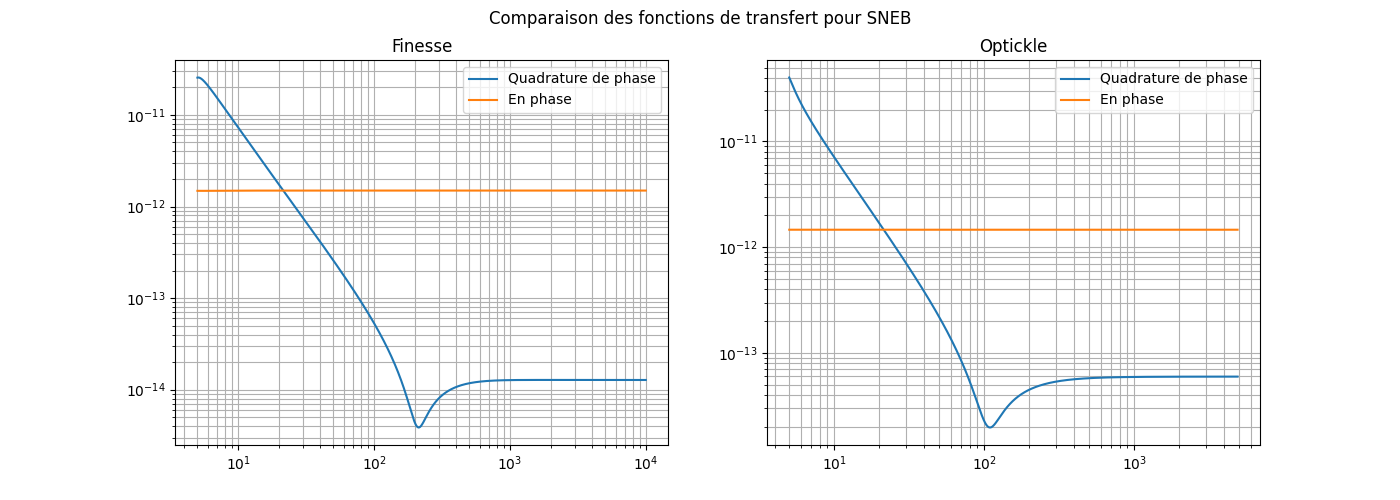

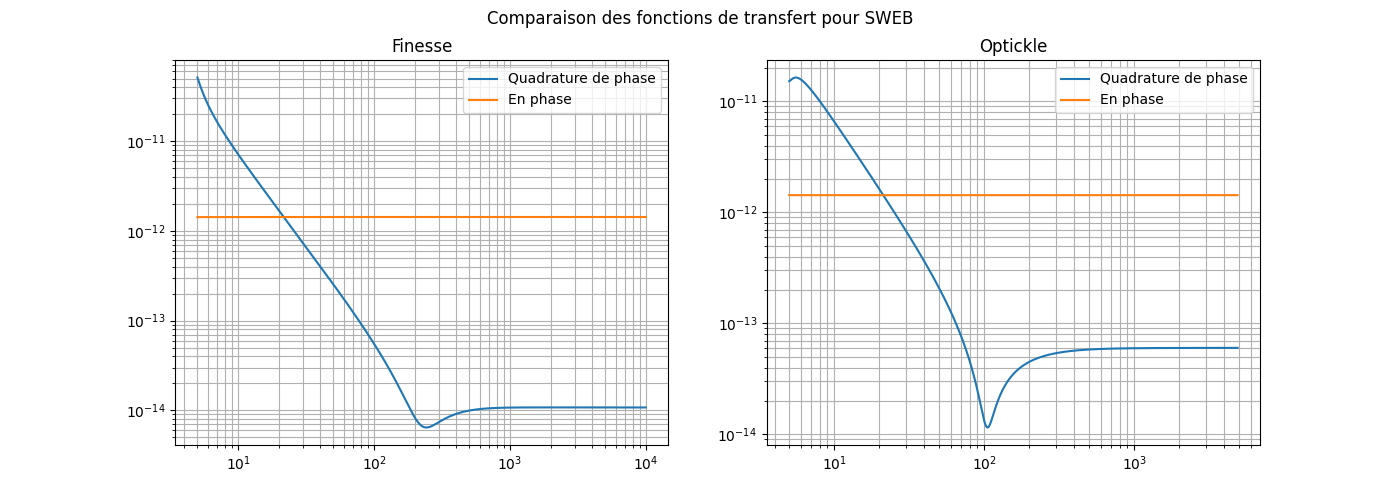

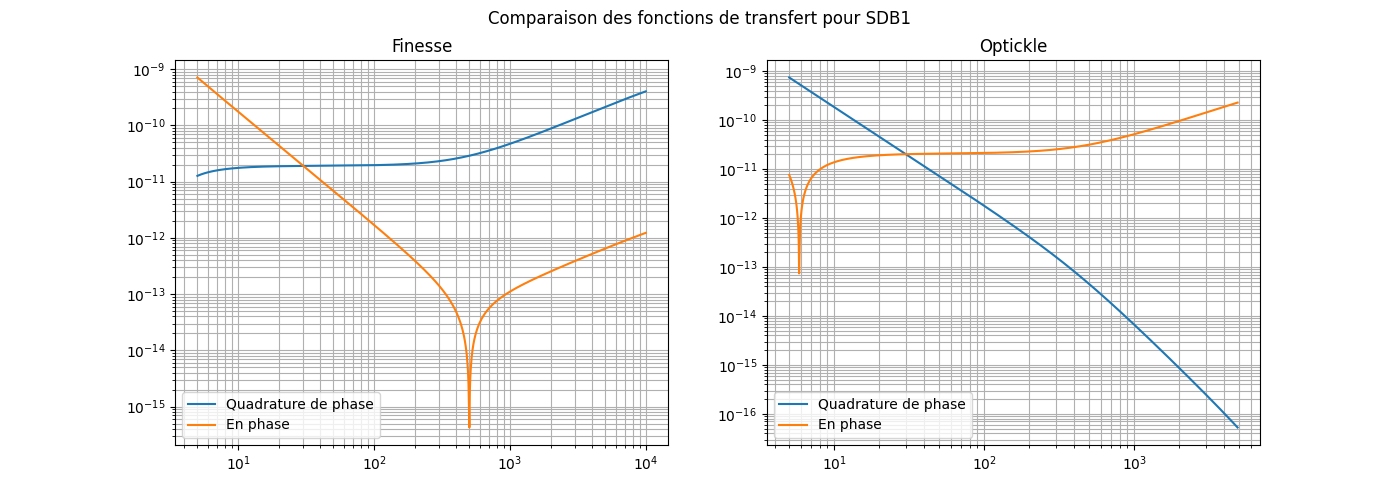

In [12]:
for bench_name in ["SNEB", "SWEB", "SDB1"]:
    in_index = 0
    if bench_name == "SDB1":
        in_index = 1
    quad_index = (1 + in_index) % 2
    Figure = figure(figsize=(14, 5))
    _ = Figure.suptitle(
        "Comparaison des fonctions de transfert pour {}".format(bench_name)
    )
    ax = Figure.add_subplot(1, 2, 1)
    _ = ax.loglog(
        quad_tf[bench_name].f,
        abs(quad_tf[bench_name][B1_detector, "{}_z".format(bench_name)])
        / abs(quad_tf["DARM"][B1_detector, "DARM"])
        / model.space_NI_NE.L.eval(),
        label="Quadrature de phase",
    )
    _ = ax.loglog(
        in_tf[bench_name].f,
        abs(in_tf[bench_name][B1_detector, "{}_z".format(bench_name)])
        / abs(in_tf["DARM"][B1_detector, "DARM"])
        / model.space_NI_NE.L.eval(),
        label="En phase",
    )
    _ = ax.set_title("Finesse")
    _ = ax.legend()
    ax.grid(True, "both", "both")
    ax = Figure.add_subplot(1, 2, 2)
    _ = ax.loglog(
        coupling_data[bench_name][quad_index].x,
        abs(coupling_data[bench_name][quad_index].y),
        label="Quadrature de phase",
    )
    _ = ax.loglog(
        coupling_data[bench_name][in_index].x,
        abs(coupling_data[bench_name][in_index].y),
        label="En phase",
    )
    _ = ax.set_title("Optickle")
    _ = ax.legend()
    ax.grid(True, "both", "both")
    show()

### En fonction du module/phase

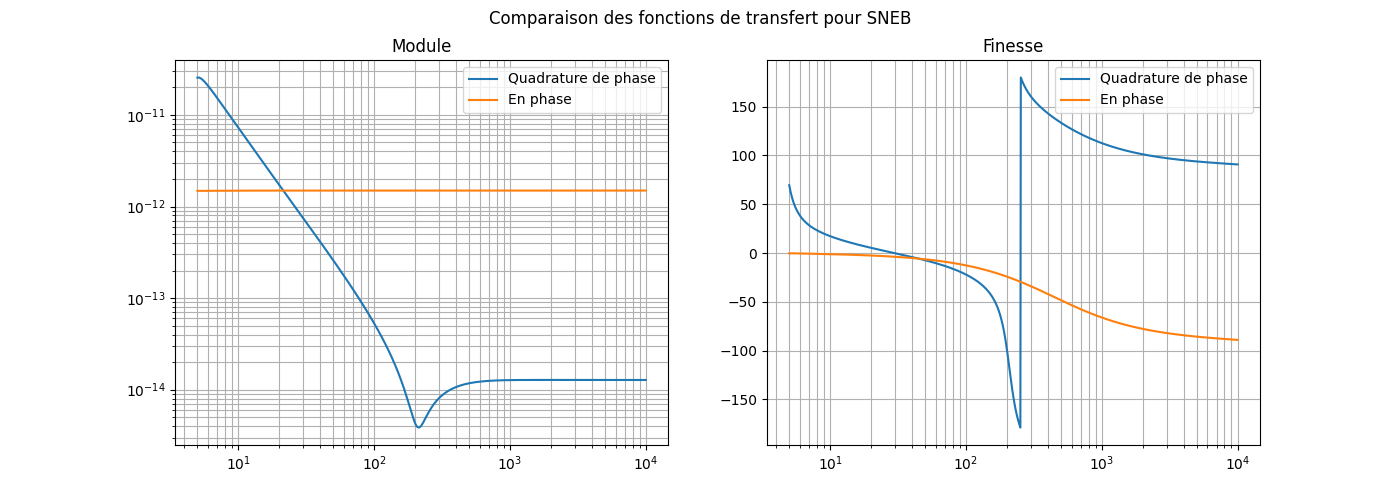

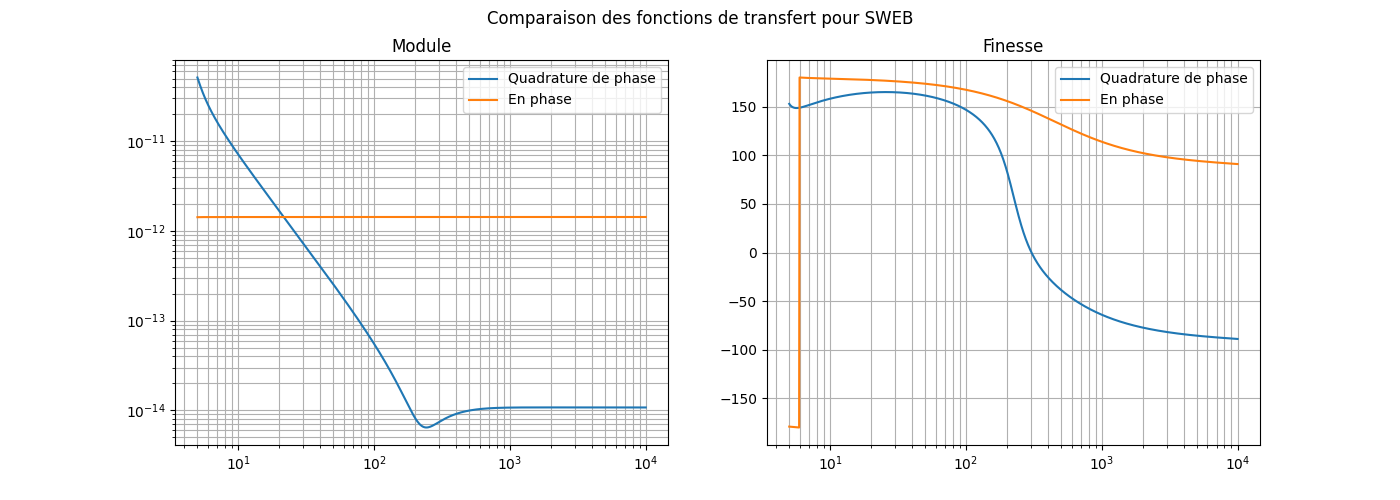

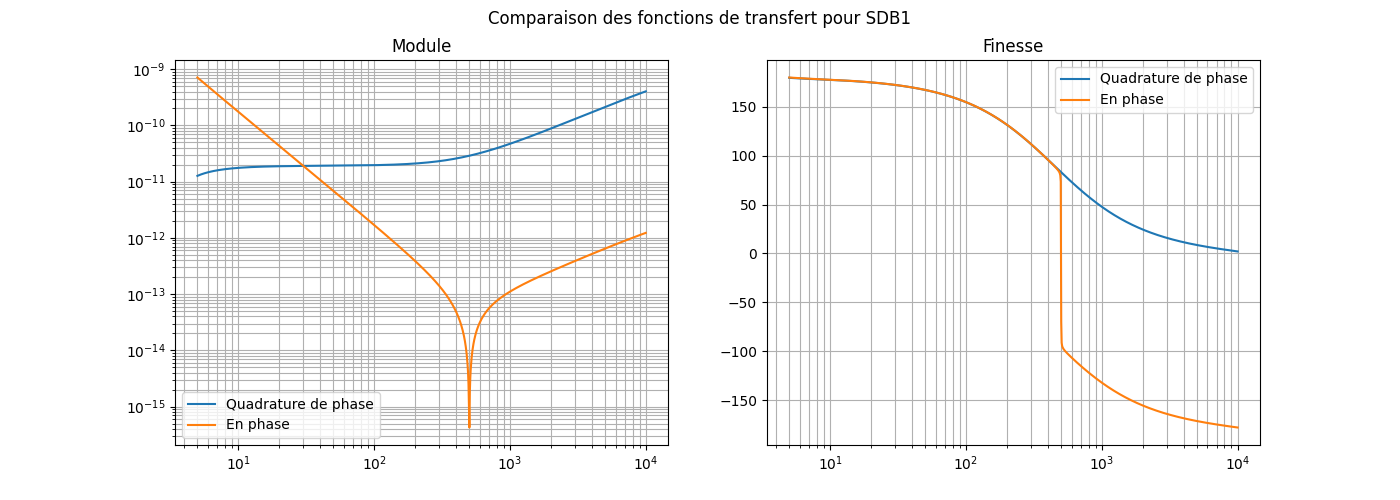

In [13]:
for bench_name in ["SNEB", "SWEB", "SDB1"]:
    Figure = figure(figsize=(14, 5))
    _ = Figure.suptitle(
        "Comparaison des fonctions de transfert pour {}".format(bench_name)
    )
    ax = Figure.add_subplot(1, 2, 1)
    _ = ax.loglog(
        quad_tf[bench_name].f,
        abs(quad_tf[bench_name][B1_detector, "{}_z".format(bench_name)])
        / abs(quad_tf["DARM"][B1_detector, "DARM"])
        / model.space_NI_NE.L.eval(),
        label="Quadrature de phase",
    )
    _ = ax.loglog(
        in_tf[bench_name].f,
        abs(in_tf[bench_name][B1_detector, "{}_z".format(bench_name)])
        / abs(in_tf["DARM"][B1_detector, "DARM"])
        / model.space_NI_NE.L.eval(),
        label="En phase",
    )
    _ = ax.set_title("Module")
    _ = ax.legend()
    ax.grid(True, "both", "both")
    ax = Figure.add_subplot(1, 2, 2)
    _ = ax.semilogx(
        quad_tf[bench_name].f,
        angle(quad_tf[bench_name][B1_detector, "{}_z".format(bench_name)]) * 180 / pi,
        label="Quadrature de phase",
    )
    _ = ax.semilogx(
        in_tf[bench_name].f,
        angle(in_tf[bench_name][B1_detector, "{}_z".format(bench_name)]) * 180 / pi,
        label="En phase",
    )
    _ = ax.set_title("Finesse")
    _ = ax.legend()
    ax.grid(True, "both", "both")
    show()